# Ensemble Climate Model EVA timeseries


This is a script to perform statistical climate change analysis on a single-model multi-member ensemble,
focussed on extreme events at a particular location.

Since the climate is not stationary, a climate model large ensemble is used to pull enough years from
a short date range. 

The code calculates and plots the following three items:

1. Map showing change in variable mean and where the changes are significant
2. Changes in extreme events at a given return period, with estimated uncertainty
3. Changes in monthly mean distributions

The script uses xarray and CMIP6 data stored in the google cloud, so no need to have data pre-downloaded. 
Only the data needed is loaded, which avoids having to download *full* GCM ensemble dataset. H

Total runtime is dependent on number of ensemble members available/specified



In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy.crs as ccrs
from scipy.signal import find_peaks
import scipy.stats as stats
import warnings

### Define parameters

In [2]:
# set parameters for the analysis
n_ens_members=2         # number of ensemble members 
sig_level=1.0           # significant level for statistical analysis, this number is multiplied with the standard deviation

# load CMIP5 databases for google cloud
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

/Users/benbronselaer/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# set model queries
# guide for names here: https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q 
# firstly set queries for both ensemble
# the format of single and double quotation marks is important, so make sure these are kept 
variable = "'tasmax'"  
resolution = "'day'"
model=  "'CanESM5'"
scenario="'ssp245'"

# then, set the historical ensemble details
activity_1="'CMIP'"
scenario_1 = "'historical'"
date_1_start ="2005-01-01"
date_1_end = "2010-12-31"

# lastly, set the future ensemble details
activity_2="'ScenarioMIP'"
scenario_2 = "'ssp245'"
date_2_start ="2035-01-01"
date_2_end = "2040-12-31"

# time resolution of requested data, in days
ts_res_days=1 

# set coordinates for location to be analyzed
# use London as example
xc=0.0
yc=51.5

# set return period to be tested
RP=100

# EVA factor: helper factor for GDP fit for extreme event analysis
# - if the variable values are very small (for example: precipitation 'pr'), the GDP fit is not accurate,
#   so it helps to adjust values to a more usable range. For precipiation 'pr', eva_func=10**5 works well
# - not needed for tasmax
eva_fac=1

In [4]:
df_ssp = df.query("activity_id== 'ScenarioMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == "+scenario)

In [5]:
models=df_ssp['source_id'].value_counts().index.tolist()
counts=df_ssp['source_id'].value_counts().tolist()

In [6]:
df_ssp['source_id'].value_counts()

MIROC6             50
CanESM5            50
EC-Earth3          16
IPSL-CM6A-LR       11
MPI-ESM1-2-LR      10
EC-Earth3-Veg       6
MRI-ESM2-0          5
UKESM1-0-LL         5
HadGEM3-GC31-LL     4
CESM2-WACCM         4
NorESM2-LM          3
ACCESS-ESM1-5       3
CESM2               3
ACCESS-CM2          3
GFDL-CM4            2
MPI-ESM1-2-HR       2
KACE-1-0-G          2
BCC-CSM2-MR         1
MIROC-ES2L          1
CMCC-CM2-SR5        1
INM-CM4-8           1
GFDL-ESM4           1
CAMS-CSM1-0         1
NorESM2-MM          1
CNRM-ESM2-1         1
NESM3               1
INM-CM5-0           1
AWI-CM-1-1-MR       1
CNRM-CM6-1          1
KIOST-ESM           1
Name: source_id, dtype: int64

### End define parameters

The next block builds the query. This is where the actual dataset is prescribed, since the rest of the code will loop through the dataframes df_hist and df_fut.

In [7]:
# data base queries
# historical ensemble query
df_hist = df.query("activity_id== " + activity_1 + " & source_id == "+model+" & table_id == "+resolution+" & variable_id == "+variable+" & experiment_id == "+scenario_1)

# future ensemble query
df_ssp = df.query("activity_id== " + activity_2 + " & source_id == "+model+" & table_id == "+resolution+" & variable_id == "+variable+" & experiment_id == "+scenario_2)
df_ssp.head()


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
240919,ScenarioMIP,CCCma,CanESM5,ssp245,r10i1p1f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r1...,NaN,20190306
241043,ScenarioMIP,CCCma,CanESM5,ssp245,r10i1p2f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r1...,NaN,20190429
241124,ScenarioMIP,CCCma,CanESM5,ssp245,r11i1p1f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r1...,NaN,20190429
241198,ScenarioMIP,CCCma,CanESM5,ssp245,r11i1p2f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r1...,NaN,20190429
241272,ScenarioMIP,CCCma,CanESM5,ssp245,r12i1p1f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r1...,NaN,20190429


Next, we define the functions that are used during the actual analysis section of the code later on.

In [8]:
## DEFINE FUNCTIONS FOR LATER USE


def standardize_dims(ds):
    # function to standardize dimension names in cmip models
    # dimension names get mapped to the keys in the rdic dictionary
    # ds = input array
    # code adapted from Julius Buseckes' CMIP6 pre-processing package
    rdic = {
        "lon": ["x", "i", "nlon", "lon", "longitude"],
        "lat": ["y", "j", "nlat", "lat", "latitude"],
        "lev": ["lev", "depth", "olevel", "zlev", "olev"],
        "time": ["time","t"],
        }
    for di in rdic.keys():
        if di not in ds.coords:
            for wrong in rdic[di]:
                if wrong in ds.coords:
                    ds=ds.rename({wrong: di})
    return ds


def prepare_timeseries(ts_h):
    # function to extract a single timeseries from an input ensemble at a given location, 
    # and returns it as a numpy array
    # ts_h= input array

    # since all the timeseries data is concatenated together, need to make note of the total number of years simulated
    n_yrs=(ts_h.time.dt.year.max()-ts_h.time.dt.year.min())*ts_h.count(dim='member')[0]  
    
    arr_np=xr.concat(ts_h,dim='time')
    return arr_np.values,n_yrs.values


def EVA2(arr_np,n_yrs,RP,ts_res_days):
    #xr.set_options(display_style='html')
    #plt.rcParams['figure.figsize'] = 12, 6
    # function to calculate probability of extreme events using a generalized pareto distribution fit
    # we also calculate an uncertainty range using a bootstrapping method (this addressed sampling uncertainty)
    # returns distribtion of extreme event values at specified return period
    # arr_np  = input numpy array
    # n_yrs = number of years simulated
    # RP = return period to be tested
    
    # set variables
    
    n_events=[70,80,90,100,120,140,160] # number of events to be extracted
    timegap_days=10 # minimum number of days between independant events
    threshold=np.percentile(arr_np,95); # set initial threshold for peak-over-threshold extreme events selection, using 99.9th percentile
    bootstrap_n=50 # number of bootstrap samples 
    out=np.zeros((len(n_events),bootstrap_n))
    # extract peaks
    idx=0
    for EV in n_events:
        peaks = extract_peaks(ts_res_days,arr_np,EV,timegap_days,threshold)
        # update threshold so the lowest value in peaks is close to zero
        threshold = peaks[0]-(peaks[1]-peaks[0])/10
        peaks=peaks-threshold
        print('Threshold: '+str(threshold))
        # calculate empirical cumulative distribution function
        q_peaks,p_peaks=ecdf(peaks+threshold)
        xx = np.linspace(0,np.max(q_peaks-threshold)*3,100)
        #initialize arrays to hold bootstrapped GPD distributions (gp_fits) and returns values (rvs)
        gp_fits=np.zeros((bootstrap_n,len(xx)))
        rvs=np.zeros((bootstrap_n,1))
        # run bootstrapping fit
        for k in range(bootstrap_n):
            # select random sample, with replacement
            b_sample=np.random.choice(peaks,len(peaks),replace=True)
            # calculate CDF
            q_peaks,p_peaks=ecdf(b_sample+threshold)
            # temporarily disable specific warnings during fitting for ease of use
            # note : other extreme value functions are simpler/cleaner to fit but are not a general as the GPD
            with np.errstate(divide='ignore', invalid='ignore'): 
                # fit GPD function
                shape, loc, scale = stats.genpareto.fit(b_sample)
            # produce continuous probability density function
            yy = stats.genpareto.pdf(xx, shape, loc, scale)
            # convert to cumumative probability from PDF
            p_gp=np.cumsum(yy)/np.sum(yy)
            # plot fits
            #plt.plot(1-np.exp(-(len(peaks)/n_yrs)*(1-p_gp)),xx+threshold, 'k',alpha=0.1)
            gp_fits[k,:]=1-np.exp(-(len(peaks)/n_yrs)*(1-p_gp))
            # calculate return value at specified return period RP
            idx = (np.abs(1-np.exp(-(len(peaks)/n_yrs)*(1-p_gp)) - 1/RP)).argmin()
            rvs[k]=xx[idx]+threshold 
        out[idx,:]=rvs
        idx+=1
    return out
    
def ecdf(sample):
    # function to calculate empirical cumulative distribution function
    # make numpy array
    # this code is adapted from stackoverflow
    sample = np.atleast_1d(sample)

    # produce quantiles and probabilities
    quantiles, counts = np.unique(sample, return_counts=True)

    # sum togther for cumulative distribution function
    cumprob = np.cumsum(counts).astype(np.double) / sample.size

    return quantiles, cumprob        
        
    
def extract_peaks(ts_res_days,timeseries,n_events,timegap_days,threshold):
    # function extract the top n_events independent events from a timeseries
    # ts_res_days = time resolution of input data, in number of days
    # timeseries = input timeseries
    # n_events = number of events to extract
    # timegap_days = the minimum number of days between independent events, default used is 5 days
    peaks, _ = find_peaks(timeseries,distance=timegap_days/ts_res_days,height=threshold)
    arr_s=np.sort(timeseries[peaks])[-n_events:]
    return arr_s



    
def is_significant(test1,test2,sig_level):
    # function to test significance of two input arrays
    if abs(np.mean(test1)  - np.mean(test2)) > sig_level*(np.std(test1)**2 + np.std(test2)**2   )**(1/2):
        return True
    else: 
        return False
    
    

    
### END DEFINE FUNCTIONS

In [9]:
models[0:5]
models2=['CanESM5', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR']

In [10]:
#df_hist = df.query("activity_id== " + activity + " & source_id == "+"'"+mod+"'"+" & table_id == "+resolution+" & variable_id == "+variable+" & experiment_id == "+scenario)
#df_hist.head()

### Get data from the cloud

In [11]:
# initialize gcfs token
print('Setting up database queries')
gcs = gcsfs.GCSFileSystem(token='anon')

# check that there are enough ensemble members for the specified analysis, otherwise update the specified number
if df_ssp.shape[0] < n_ens_members:
    n_ens_members=df_ssp.shape[0]
    print('Ensemble members updated to '+str(n_ens_members))

base_std=[] 
base_mean=[]   
ens_mean=[]
ens_std=[]
for mod in models2:
    for dates in np.linspace(2006,2066,7):    
        print('Working on dates '+str(int(dates))+'-'+str(int(dates)+9)+' for model '+str(mod))
        # prepare dates
        if dates < 2014.0:
            activity="'CMIP'"
            scenario = "'historical'"
            date_start =str(int(dates))+"-01-01"
            date_end = str(int(dates)+9)+"-12-31"

        
        if dates > 2014.0:
            activity="'ScenarioMIP'"
            scenario = "'ssp245'"
            date_start =str(int(dates))+"-01-01"
            date_end = str(int(dates)+9)+"-12-31"
    
        df_hist = df.query("activity_id== " + activity + " & source_id == "+"'"+mod+"'"+" & table_id == "+resolution+" & variable_id == "+variable+" & experiment_id == "+scenario)

        # these two loops pull the past and future ensemble data from the cloud
        for i in range(n_ens_members):
            zstore = df_hist.zstore.values[i]

            # create a mutable-mapping-style interface to the store 
            mapper = gcs.get_mapper(zstore)

            # open data and select time slice 
            ds = xr.open_zarr(mapper, consolidated=True)
            ens_m=ds[variable[1:-1]].sel(time=slice(date_start,date_end))
            ens_m=ens_m.sel(lon=xc,lat=yc, method="nearest")
            %time ens_m.load()
            if i == 0:
                ens_hist=ens_m
            else:
                ens_hist=xr.concat([ens_hist,ens_m], 'member')

        # rename dimensions to standard names
        ens_hist=standardize_dims(ens_hist)
        
        # prepare timeseries
        arr_n,n_yrs = prepare_timeseries(ens_hist)
    
        base_mean=np.append(base_mean,np.mean(arr_n))
        base_std=np.append(base_mean,np.std(arr_n))
    
        # run EVA analysis
        rvs=EVA(eva_fac*arr_n,n_yrs,RP,ts_res_days)
    
        ens_mean=np.append(ens_mean,np.mean(rvs))
        ens_std=np.append(ens_std,np.std(rvs))
        
        del ens_hist
        del ens_m 
        del ds
    


Setting up database queries
Working on dates 2006-2015 for model CanESM5
CPU times: user 893 ms, sys: 361 ms, total: 1.25 s
Wall time: 10 s
CPU times: user 846 ms, sys: 324 ms, total: 1.17 s
Wall time: 9.99 s
Threshold: 294.07073669433595
Working on dates 2016-2025 for model CanESM5
CPU times: user 1.58 s, sys: 678 ms, total: 2.26 s
Wall time: 18.9 s
CPU times: user 1.2 s, sys: 467 ms, total: 1.66 s
Wall time: 14.4 s
Threshold: 295.5218505859375
Working on dates 2026-2035 for model CanESM5
CPU times: user 1.56 s, sys: 629 ms, total: 2.19 s
Wall time: 21.4 s
CPU times: user 1.18 s, sys: 468 ms, total: 1.65 s
Wall time: 13.9 s
Threshold: 295.89133605957034
Working on dates 2036-2045 for model CanESM5
CPU times: user 1.55 s, sys: 626 ms, total: 2.18 s
Wall time: 18.7 s
CPU times: user 1.17 s, sys: 470 ms, total: 1.64 s
Wall time: 14 s
Threshold: 296.3198638916016
Working on dates 2046-2055 for model CanESM5
CPU times: user 757 ms, sys: 265 ms, total: 1.02 s
Wall time: 9.84 s
CPU times: us

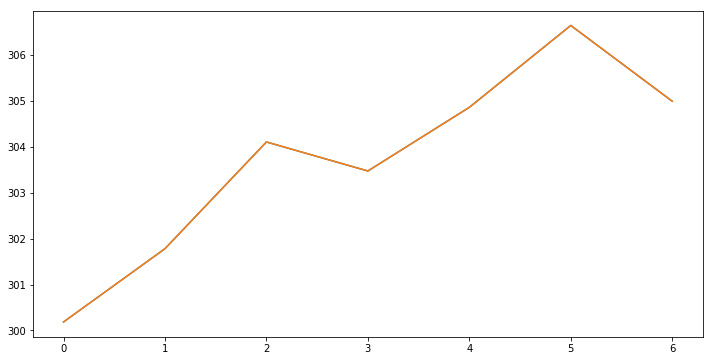

In [25]:

ensm2=np.reshape(ens_mean, (len(models2),7))
enss2=np.reshape(ens_std, (len(models2),7))


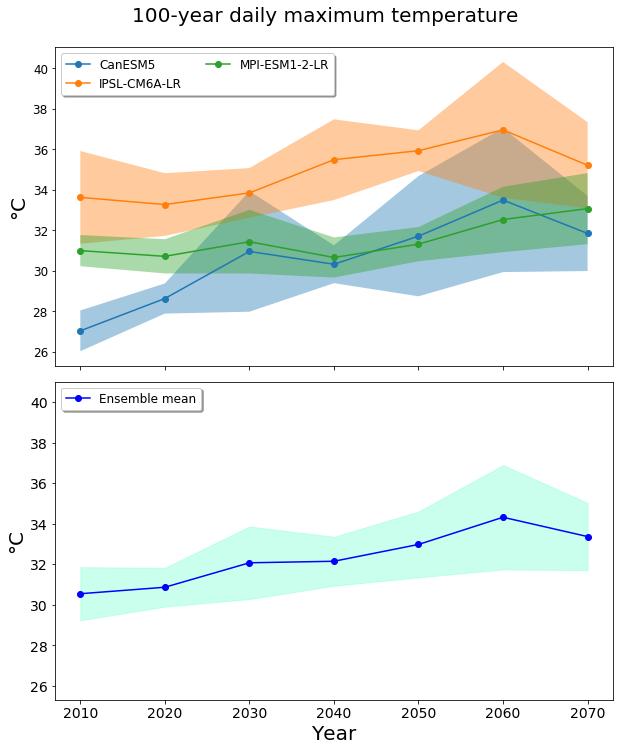

In [105]:
ensm2=np.reshape(ens_mean, (len(models2),7))
enss2=np.reshape(ens_std, (len(models2),7))
plt.rcParams['figure.figsize'] = 10, 12
fig, axs = plt.subplots(2, sharex=True, sharey=True, gridspec_kw={'hspace': 0.05})

for m in range(len(models2)):
    axs[0].fill_between(np.linspace(2006,2066,7)+4,ensm2[m,:]-2*enss2[m,:]-273.15,ensm2[m,:]+2*enss2[m,:]-273.15, alpha='0.4')
    axs[0].plot(np.linspace(2006,2066,7)+4,ensm2[m,:]-273.15,'o-',label=str(models2[m]))
for ax in axs.flat:
    ax.set_ylabel('\N{DEGREE SIGN}C',fontsize=20)
axs[1].set_xlabel('Year',fontsize=20)
axs[0].legend(loc="upper left", bbox_to_anchor=[0, 1],
                 ncol=2, shadow=True, fancybox=True,fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)

# combine model estimates
ensm2=np.mean(ensm2,axis=0)
enss2=np.sum(enss2**2,axis=0)**(1/2)/(len(models2)-1)
axs[1].fill_between(np.linspace(2006,2066,7)+4,ensm2-2*enss2-273.15,ensm2+2*enss2-273.15, color='aquamarine', alpha='0.4')
axs[1].plot(np.linspace(2006,2066,7)+4,ensm2-273.15,'bo-',label="Ensemble mean")
axs[1].legend(loc="upper left", bbox_to_anchor=[0, 1],
                 ncol=2, shadow=True, fancybox=True,fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=14)
fig.text(0.5,0.91,
        '100-year daily maximum temperature',
        horizontalalignment='center',fontsize=20)
fig.savefig('EVA_multi-model.png', dpi=200)

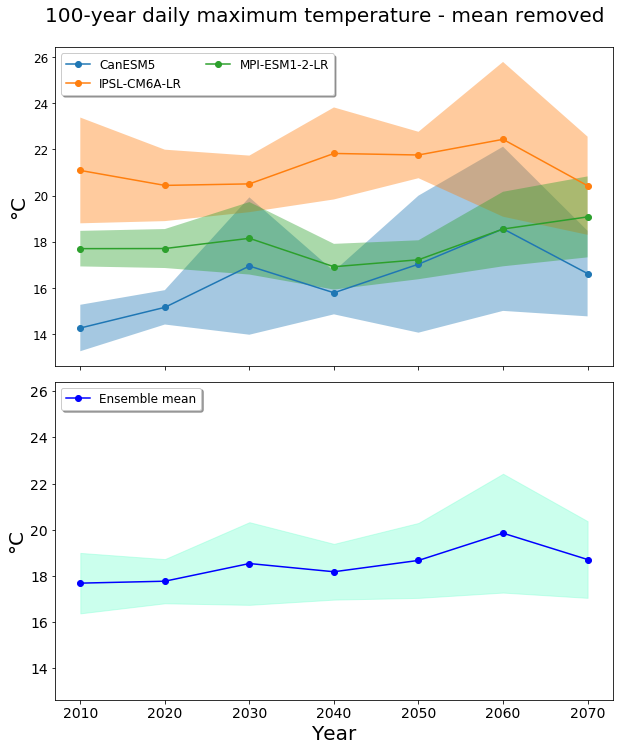

In [107]:
ensm2=np.reshape(ens_mean, (len(models2),7))
enss2=np.reshape(ens_std, (len(models2),7))
bm=np.reshape(base_mean, (len(models2),7))

plt.rcParams['figure.figsize'] = 10, 12
fig, axs = plt.subplots(2, sharex=True, sharey=True, gridspec_kw={'hspace': 0.05})

for m in range(len(models2)):
    axs[0].fill_between(np.linspace(2006,2066,7)+4,ensm2[m,:]-2*enss2[m,:]-bm[m,:],ensm2[m,:]+2*enss2[m,:]-bm[m,:], alpha='0.4')
    axs[0].plot(np.linspace(2006,2066,7)+4,ensm2[m,:]-bm[m,:],'o-',label=str(models2[m]))
for ax in axs.flat:
    ax.set_ylabel('\N{DEGREE SIGN}C',fontsize=20)
axs[1].set_xlabel('Year',fontsize=20)
axs[0].legend(loc="upper left", bbox_to_anchor=[0, 1],
                 ncol=2, shadow=True, fancybox=True,fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)

# combine model estimates
ensm2=np.mean(ensm2,axis=0)
enss2=np.sum(enss2**2,axis=0)**(1/2)/(len(models2)-1)
bm=np.mean(bm,axis=0)
axs[1].fill_between(np.linspace(2006,2066,7)+4,ensm2-2*enss2-bm,ensm2+2*enss2-bm, color='aquamarine', alpha='0.4')
axs[1].plot(np.linspace(2006,2066,7)+4,ensm2-bm,'bo-',label="Ensemble mean")
axs[1].legend(loc="upper left", bbox_to_anchor=[0, 1],
                 ncol=2, shadow=True, fancybox=True,fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=14)
fig.text(0.5,0.91,
        '100-year daily maximum temperature - mean removed',
        horizontalalignment='center',fontsize=20)
fig.savefig('EVA_multi-model_mean_removed.png', dpi=200)

Text(0, 0.5, 'Degrees C')

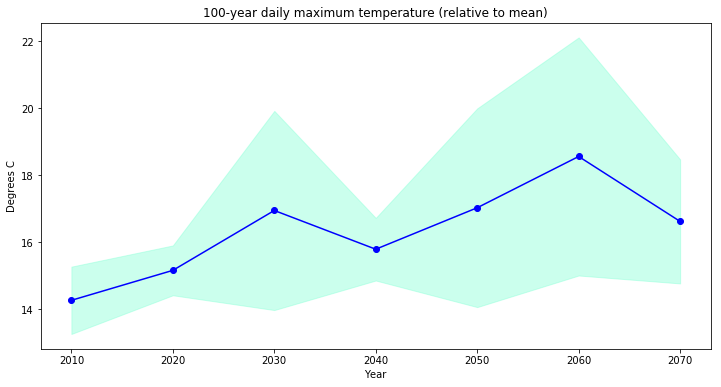

In [48]:
plt.rcParams['figure.figsize'] = 12, 6
plt.fill_between(np.linspace(2006,2066,7)+4,ens_mean[:7]-2*ens_std[:7]-base_mean[:7],ens_mean[:7]+2*ens_std[:7]-base_mean[:7], color='aquamarine', alpha='0.4')
plt.plot(np.linspace(2006,2066,7)+4,ens_mean[:7]-base_mean[:7],'bo-')
plt.title('100-year daily maximum temperature (relative to mean)')
plt.xlabel('Year')
plt.ylabel('Degrees C')

### Test for significance
This next cell calculates whether there is a significant change in the specified return period extreme event

In [ ]:
# test significance

    
print('Significance test:')
if is_significant(rvs_fut,rvs_hist,sig_level):
    print("Likely significant change in " + ens_hist.long_name+ " at year " + str(RP) + " from " + str(round(np.mean(rvs_hist),2)/eva_fac) + 
    " to "+ str(round(np.mean(rvs_fut),2)/eva_fac)+ " " + ens_hist.units)
else: 
    print("Likely no change in " + ens_hist.long_name+ " at year " + str(RP) + " from " + str(round(np.mean(rvs_hist),2)/eva_fac)+ " "+ ens_hist.units)    
     

### Monthly differences

Plot histograms of monthly means, maxima, and/or minima

In [ ]:
np.linspace(2006,2066,7)

In [ ]:
ds.time